In [1]:
#q-learning

In [2]:
#https://github.com/feknall/gym-mountain-car/blob/master/mountain_car_v0.py

In [3]:
#https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

In [4]:

"""
http://incompleteideas.net/MountainCar/MountainCar1.cp
permalink: https://perma.cc/6Z2N-PFWC
"""
import math
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


class Custom_MountainCarEnv(gym.Env):
    """
    ### Description
    The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
    at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
    that can be applied to the car in either direction. The goal of the MDP is to strategically
    accelerate the car to reach the goal state on top of the right hill. There are two versions
    of the mountain car domain in gym: one with discrete actions and one with continuous.
    This version is the one with discrete actions.
    This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)
    ```
    @TECHREPORT{Moore90efficientmemory-based,
        author = {Andrew William Moore},
        title = {Efficient Memory-based Learning for Robot Control},
        institution = {University of Cambridge},
        year = {1990}
    }
    ```
    ### Observation Space
    The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
    | Num | Observation                          | Min  | Max | Unit         |
    |-----|--------------------------------------|------|-----|--------------|
    | 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
    | 1   | velocity of the car                  | -Inf | Inf | position (m) |
    ### Action Space
    There are 3 discrete deterministic actions:
    | Num | Observation             | Value | Unit         |
    |-----|-------------------------|-------|--------------|
    | 0   | Accelerate to the left  | Inf   | position (m) |
    | 1   | Don't accelerate        | Inf   | position (m) |
    | 2   | Accelerate to the right | Inf   | position (m) |
    ### Transition Dynamics:
    Given an action, the mountain car follows the following transition dynamics:
    *velocity<sub>t+1</sub> = velocity<sub>t</sub> + (action - 1) * force - cos(3 * position<sub>t</sub>) * gravity*
    *position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>*
    where force = 0.001 and gravity = 0.0025. The collisions at either end are inelastic with the velocity set to 0
    upon collision with the wall. The position is clipped to the range `[-1.2, 0.6]` and
    velocity is clipped to the range `[-0.07, 0.07]`.
    ### Reward:
    The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is
    penalised with a reward of -1 for each timestep.
    ### Starting State
    The position of the car is assigned a uniform random value in *[-0.6 , -0.4]*.
    The starting velocity of the car is always assigned to 0.
    ### Episode End
    The episode ends if either of the following happens:
    1. Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
    2. Truncation: The length of the episode is 200.
    ### Arguments
    ```
    gym.make('MountainCar-v0')
    ```
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.tau = 1.0 # seconds between state updates
        self.tau1 =self.tau/20 #.05 # integration time sample
        #self.force = 0.001
        #self.force_mag = 0.001
        self.one_over_mass = 0.001 # mass in kg, replaces 1/self.force
        self.gravity = 0.0025

        self.low = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position, self.max_speed], dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)

                ### Customization changes ######
        '''add ElectricalDCMotorEnv to the CartPole class
        and assign values to
        Resistor_R, inductor_L, torque_const_Kt and bemf_const_Ke'''
        #self.tau = 0.02 #############################################################################
        #self.Resistor_R=1.0
        #self.inductor_L=0.1
        #self.torque_const_Kt=1.0
        #self.bemf_const_Ke=1.0
        self.DCMotorModel = ElectricalDCMotorEnv()
        self.DCMotorModel.tau = self.tau1
        self.DCMotorModel.Resistor_R = 1.0
        self.DCMotorModel.inductor_L = 0.1
        self.DCMotorModel.torque_const_Kt = 1.0
        self.DCMotorModel.bemf_const_Ke = 1.0
        self.DCMotorModel.current = 0.0
        self.DCMotorModel.current_error = 0.0
        self.DCMotorModel.current_error_acc = 0.0
        self.DCMotorModel.current_error_prev = 0.0
        ####



    def step(self, action: int):
        assert self.action_space.contains( action ), f"{action!r} ({type(action)}) invalid"

        position, velocity = self.state
        wanted_force = action - 1 # disired forces in Newton = {-1,0,+1}[N]
        current_ref = wanted_force/self.DCMotorModel.torque_const_Kt
        #F = self.DCMotorModel.step(current_ref = current_ref, x_dot = velocity)#############################################

        for t in np.arange(start=0.0, stop=self.tau, step=self.tau1):
          #generates actual force, u_after_pid
          actual_force = self.DCMotorModel.step(current_ref = current_ref, x_dot = velocity)##########################################################
          #actual_force = wanted_force #+ np.random.randn()*0.01

          # NOTE: if tau=1 and tau1=1 and actual_force=force (no feed thru PID),
          #      then we have the "ideal" mountain car ENV

          #actual force is divded by 0.0015 (defult) kg mass
          velocity += (actual_force*self.one_over_mass - self.gravity * math.cos(3 * position))*self.tau1
          if velocity > self.max_speed:
              velocity = self.max_speed
          if velocity < -self.max_speed:
              velocity = -self.max_speed
          position += (velocity)*self.tau1
          if position > self.max_position:
              position = self.max_position
          if position < self.min_position:
              position = self.min_position
          if position == self.min_position and velocity < 0:
              velocity = 0

        terminated = bool(
            position >= self.goal_position #and velocity >= self.goal_velocity
        )
        reward = -1.0

        self.state = (position, velocity)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False ,wanted_force , actual_force###############################################################################################

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(options, -0.6, -0.4)
        self.state = np.array([self.np_random.uniform(low=low, high=high), 0])

        ### zerowise DC motor init. conditions
        self.DCMotorModel.current = 0.0
        self.DCMotorModel.current_error = 0.0
        self.DCMotorModel.current_error_acc = 0.0
        self.DCMotorModel.current_error_prev = 0.0

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def _height(self, xs):
        return np.sin(3 * xs) * 0.45 + 0.55

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.max_position - self.min_position
        scale = self.screen_width / world_width
        carwidth = 40
        carheight = 20

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 50
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def get_keys_to_action(self):
        # Control with left and right arrow keys.
        return {(): 1, (276,): 0, (275,): 2, (275, 276): 1}

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
class ElectricalDCMotorEnv():

      def __init__(self):
        self.Resistor_R = 1.0
        self.inductor_L = 0.1
        self.torque_const_Kt = 1.0
        self.bemf_const_Ke = 1.0
        self.tau = 0.02###############################################################################################################################################or 1
        #
        #self.Kp = 1.0
        #self.Ki = 0.1
        #self.Kd = 10**(-3.5)
        #self.aL=10**(-3)+(7./3 - 4./3 -1)#Low pass parameter
        #self.aH = 10**2 #High pass parameter

        self.Kp = 2.0
        self.Ki = 10.0
        self.Kd = 10**(-6)
        #self.Kp = 2.0
        #self.Ki = 17.0
        #self.Kd = 1
        self.aL=10.0**(-3) #Low pass parameter
        self.aH = 10.0**2 #High pass parameter
        #
        self.current = 0.0
        self.current_error = 0.0
        self.current_error_acc = 0.0
        self.current_error_prev = 0.0
        self.voltage_input = 0.0
        self.xdot = 0.0
        #self.PID_Discretization = "Simple" #"Backward", " "Bilinear" , "Forward" "Simple"
        #self.PID_Discretization = "Backward" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"
        self.PID_Discretization = "Simple" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"

      def step(self, current_ref, x_dot):
        aL = self.aL
        aH = self.aH
        self.current_error = current_ref-self.current
        delta_error = self.current_error-self.current_error_prev

        if self.PID_Discretization == "Simple":
          self.current_error_acc += self.current_error*self.tau
          HP_delta_error = delta_error

        elif self.PID_Discretization == "Backward":
          self.current_error_acc = (self.current_error_acc+(self.current_error)*self.tau)/(1+aL*self.tau) #Low Pass
          HP_delta_error = (self.current_error + aH*delta_error)/(1+aL*self.tau)#High Pass

        elif self.PID_Discretization == "Bilinear":
          error_avg = (self.current_error+self.current_error_prev)/2
          self.current_error_acc =  ((1-aL*self.tau/2)*self.current_error_acc + error_avg*self.tau)/(1+aL*self.tau/2)#Low Pass
          HP_delta_error =  ((1-aL*self.tau/2)*self.current_error + aH*delta_error)/(1+aL*self.tau/2)#High Pass

        else:
          self.current_error_acc = (1-aL*self.tau)*self.current_error_acc+(self.current_error_prev)*self.tau #Low Pass
          HP_delta_error = (1-aH*self.tau)*self.current_error + aH*delta_error #High Pass

        P = self.Kp*self.current_error
        #I = self.Ki*self.current_error_acc*self.tau
        I = self.Ki*self.current_error_acc
        #D = self.Kd*HP_delta_error/self.tau
        D = self.Kd*HP_delta_error/self.tau
        voltage_BEMF = x_dot*self.bemf_const_Ke
        voltage_input = P+I+D+voltage_BEMF
        voltage_input=np.clip(voltage_input,-10,10)

        self.current_error_prev = 0+self.current_error
        self.current += self.tau*(voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L
        self.voltage_input = voltage_input
        self.current = np.clip(self.current,-2,2)
        self.xdot = x_dot
        F=self.torque_const_Kt*self.current

        return F # return applied Force

In [6]:
env =  Custom_MountainCarEnv()
env.DCMotorModel.PID_Discretization ="Simple" # "Forward" or "Backward" or" "Bilinear" or "Simple"

In [7]:
#a
import gym
import numpy as np
import imageio

#env = gym.make("MountainCar-v0")############################################################################################################################
env = Custom_MountainCarEnv()
env.reset()

LEARNING_RATE = 0.1
DISCOUNT = 0.95
#EPISODES = 10000
EPISODES = 1000

SHOW_EVERY = 200

DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)

discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))


def get_discrete_state(state):
    #print("state :", state)
    #print("env.observation_space.low :",env.observation_space.low)
    #state = state[0]##################################################################################################################################################
    #print("state :", state)
    discrete_state = (state - env.observation_space.low) / discrete_os_win_size
    return tuple(discrete_state.astype(np.int))

counter = 0

plotting_rewards=[]

save_observation = []
save_u1 = []
save_pid_u1 = []

for episode in range(EPISODES):
    if episode % SHOW_EVERY == 0:
        render = True
    else:
        render = False

    if counter == 0:
      state = env.reset()
      state = state[0]
      #print("state_1 :",state)
      counter +=1
    else:
      state = env.reset

    discrete_state = get_discrete_state(state)
    frames = []
    done = False
    score = 0
    while not done:
        action = np.argmax(q_table[discrete_state])# Indexes of the maximum values along an axis
        #np.array(self.state, dtype=np.float32), reward, terminated, False ,action , F
        #print("q_table[discrete_state] :", q_table[discrete_state])
        #print("action :", action)
        new_state, reward, done, _ , u , u_after_pid= env.step(action)


        if episode == EPISODES - 1 :

          save_observation.append(new_state)
          save_u1.append(u)
          save_pid_u1.append(u_after_pid)


        score += reward
        new_discrete_state = get_discrete_state(new_state)
        #if render:
        #    frames.append(env.render(mode="rgb_array"))




        if not done:

            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action, )]

            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action, )] = new_q
        elif new_state[0] >= env.goal_position:
            #print(f"Congratulation! We reached to the goal! Episode: {episode}")
            q_table[discrete_state + (action, )] = 0
            counter = 0###################################################################################################################

        discrete_state = new_discrete_state

    plotting_rewards.append(score)
    # Print the final score
    print(f"EPISODE: {episode + 1} - FINAL SCORE: {score} ") # Print the final score

    #if render:
    #    print(frames[0].shape)
     #   imageio.mimsave(f'./{episode}.gif', frames, fps=40)

env.close()

<ipython-input-7-eacb9f35c3a9>:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


EPISODE: 1 - FINAL SCORE: -3489.0 
EPISODE: 2 - FINAL SCORE: -3209.0 
EPISODE: 3 - FINAL SCORE: -4776.0 
EPISODE: 4 - FINAL SCORE: -4101.0 
EPISODE: 5 - FINAL SCORE: -3413.0 
EPISODE: 6 - FINAL SCORE: -6094.0 
EPISODE: 7 - FINAL SCORE: -2990.0 
EPISODE: 8 - FINAL SCORE: -1685.0 
EPISODE: 9 - FINAL SCORE: -1735.0 
EPISODE: 10 - FINAL SCORE: -2437.0 
EPISODE: 11 - FINAL SCORE: -2016.0 
EPISODE: 12 - FINAL SCORE: -3908.0 
EPISODE: 13 - FINAL SCORE: -3236.0 
EPISODE: 14 - FINAL SCORE: -2297.0 
EPISODE: 15 - FINAL SCORE: -2864.0 
EPISODE: 16 - FINAL SCORE: -1700.0 
EPISODE: 17 - FINAL SCORE: -1658.0 
EPISODE: 18 - FINAL SCORE: -1329.0 
EPISODE: 19 - FINAL SCORE: -3170.0 
EPISODE: 20 - FINAL SCORE: -1337.0 
EPISODE: 21 - FINAL SCORE: -1411.0 
EPISODE: 22 - FINAL SCORE: -2160.0 
EPISODE: 23 - FINAL SCORE: -2512.0 
EPISODE: 24 - FINAL SCORE: -1805.0 
EPISODE: 25 - FINAL SCORE: -2398.0 
EPISODE: 26 - FINAL SCORE: -1416.0 
EPISODE: 27 - FINAL SCORE: -1402.0 
EPISODE: 28 - FINAL SCORE: -803.0 
EP

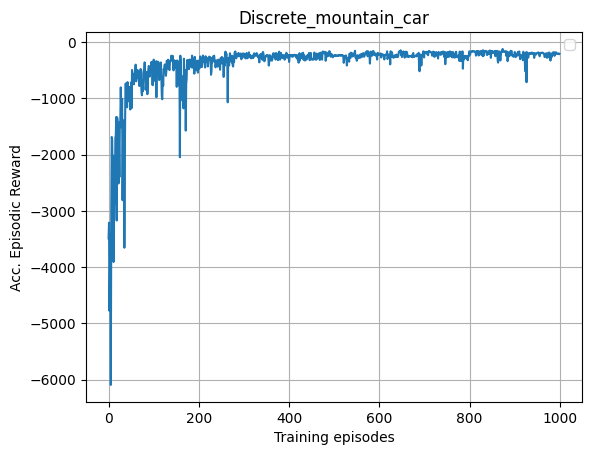

In [8]:
import matplotlib.pyplot as plt


plt.plot(plotting_rewards)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')

plt.grid()
plt.legend()
plt.title('Discrete_mountain_car')
plt.show()

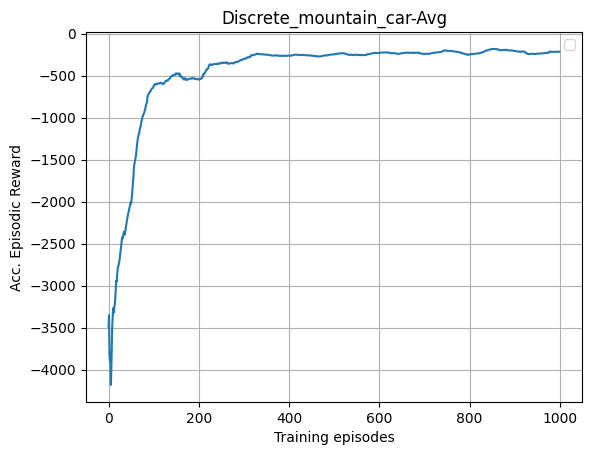

In [9]:
N=50
# Compute the moving average of the last 50 numbers
moving_average = []
for i, n in enumerate(plotting_rewards):
    if i < N:
        # If there are not enough previous elements,
        # append the average of all available elements
        avg = sum(plotting_rewards[:i+1]) / (i+1)
    else:
        # Otherwise, compute the average of the previous 5 elements
        avg = sum(plotting_rewards[i-N:i+1]) / N
    moving_average.append(avg)

# Plot the moving average
plt.plot(moving_average)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')

plt.grid()
plt.legend()
plt.title('Discrete_mountain_car-Avg')
plt.show()

In [10]:
print("Last avg of", N, "Eposides = ", avg)

Last avg of 50 Eposides =  -215.88


In [11]:
dt=1

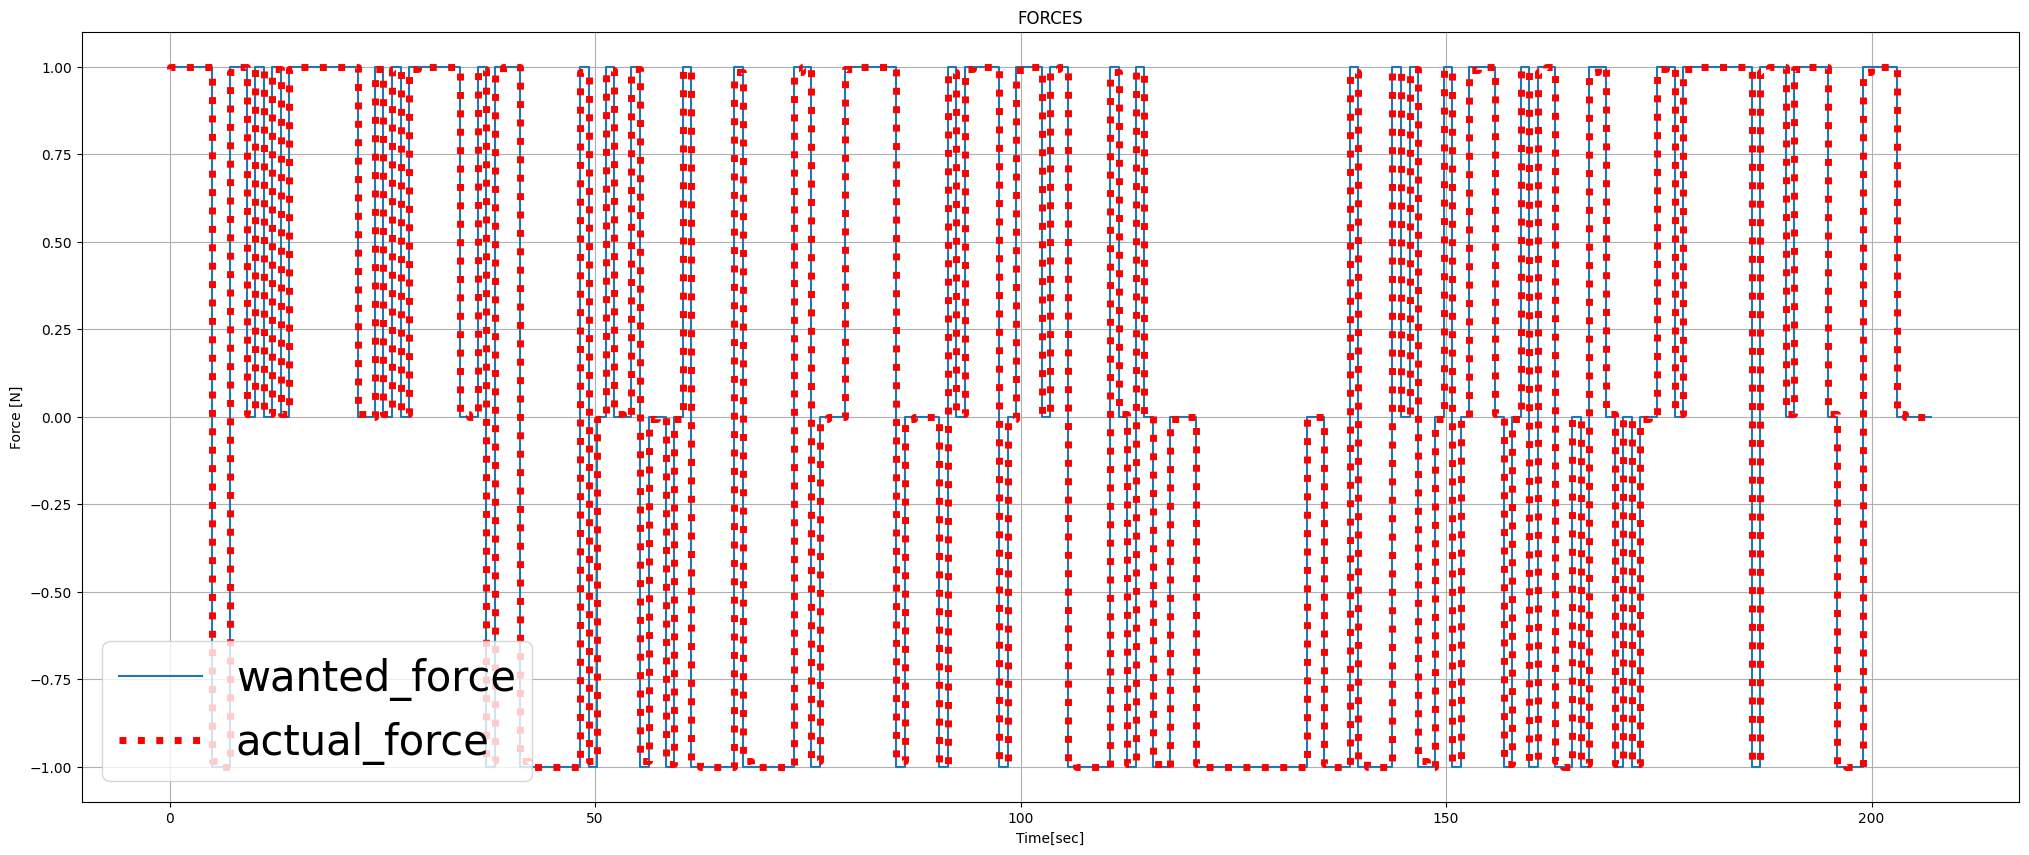

In [25]:
time_position_u1= np.linspace(start = 0, stop = len(save_u1)*dt,num=len(save_u1) )
time_position__pid_u1= np.linspace(start = 0, stop = len(save_u1)*dt,num=len(save_u1) )

f = plt.figure()
f.set_figwidth(25)
f.set_figheight(10)

plt.step(time_position_u1, save_u1 ,label = "wanted_force")
plt.step(time_position__pid_u1, save_pid_u1, linestyle = ':', linewidth=5,label = "actual_force",color="red")
plt.ylabel('Force [N]')
plt.xlabel('Time[sec]')
#plt.ylim(-0.09, 0.05)
plt.grid()
plt.legend(fontsize=30, title_fontsize=20)
plt.title('FORCES')
plt.show()

In [18]:
import math

position_print = []
velocity_print = []


for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      position_print.append(value)

    if index == 1:
      velocity_print.append(value)


In [19]:
print(len(position_print))

207


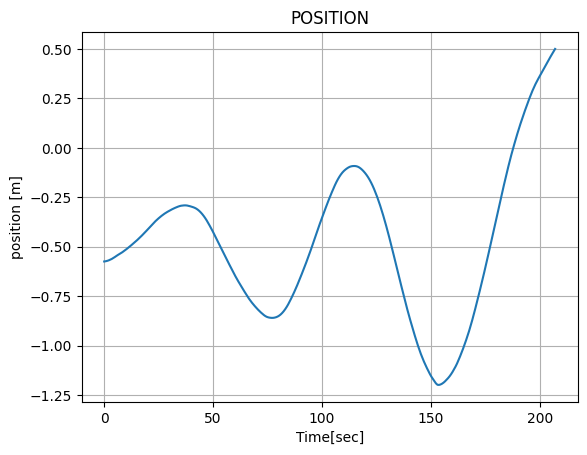

In [20]:
from scipy.interpolate import make_interp_spline, BSpline

time_position_print = np.linspace(start = 0, stop = len(position_print)*dt,num=len(position_print))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_position_print[-1] , 300)

spl = make_interp_spline(time_position_print, position_print, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.ylabel('position [m]')
plt.xlabel('Time[sec]')
plt.grid()
#plt.legend()
plt.title('POSITION')
plt.show()

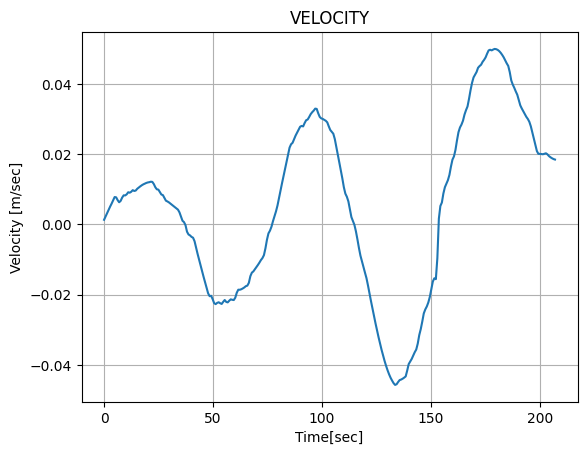

In [21]:
from scipy.interpolate import make_interp_spline, BSpline

time_velocity_print = np.linspace(start = 0, stop = len(velocity_print)* dt,num=len(velocity_print))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_velocity_print[-1] , 300)

spl = make_interp_spline(time_velocity_print, velocity_print, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.ylabel('Velocity [m/sec]')
plt.xlabel('Time[sec]')
plt.grid()
#plt.legend()
plt.title('VELOCITY')
plt.show()